## Credit Card Application

### Goals: To investigate why borrowers are unable to repay their credit card debt and decide which applicants are eligible to apply for the credit card.

In [25]:
# Import Essential Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


### Data Cleaning & Preparation
Credit Record

In [26]:
# Mount File
credit_record = pd.read_csv('credit_record.csv', header = 0)

# Handle duplicates from credit_record (Keep the "worse" record)
credit_record = credit_record.sort_values('STATUS').drop_duplicates('ID', keep='last')

# Change months balance into age of account
credit_record['MONTHS_BALANCE'] *= -1

# Since 'X' means no loan taken, remove X. Then, change status to numerical values
credit_record = credit_record[credit_record['STATUS'] != 'X']

# Convert status to linear values (0 means paid on time, 6 means bank has already deemed uncollectible)
credit_record['STATUS'].replace('C', 0, inplace = True)
credit_record = credit_record.astype(int)

# Create new column - check if customer has missed payments before
credit_record['Loan Default'] = np.where(credit_record['STATUS'] != 0, 1, 0)

# Rename Columns
credit_record.rename(columns = {'STATUS':'Days Overdue', 'MONTHS_BALANCE' : 'Account Age'}, inplace = True)


### Data Cleaning & Preparation
Adding application record

In [27]:
# Mount File
application_record = pd.read_csv('application_record.csv', header = 0)

# Handle duplicates from application_record
application_record = application_record.drop_duplicates('ID', keep='last')

# Insert application details to credit record
credit_data = pd.merge(credit_record,application_record,on ='ID', how ='inner')

# Combine number of phones
credit_data['Phone Count'] = credit_data['FLAG_MOBIL'] + credit_data['FLAG_PHONE'] + credit_data['FLAG_WORK_PHONE']
credit_data.drop(columns=['FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE'], inplace = True)

# Drop redundant information
credit_data.drop(columns=['OCCUPATION_TYPE', 'FLAG_EMAIL', 'NAME_INCOME_TYPE'], inplace = True)

# Change categorical variables to binary
credit_data['CODE_GENDER'].replace(['M','F'], [1,0], inplace = True) # Male = 1, Female = 0
credit_data['FLAG_OWN_CAR'].replace(['Y','N'], [1,0], inplace = True) # Own car = 1
credit_data['FLAG_OWN_REALTY'].replace(['Y','N'], [1,0], inplace = True) # Own property = 1
credit_data['NAME_FAMILY_STATUS'] = np.where((credit_data['NAME_FAMILY_STATUS'] == 'Married') | (credit_data['NAME_FAMILY_STATUS'] == 'Civil marriage'), 1, 0) # Married = 1

# Represent income in '000s
credit_data['AMT_INCOME_TOTAL'] /= 1000

# Represent employment duration
credit_data['DAYS_EMPLOYED'] = np.where(credit_data['DAYS_EMPLOYED'] <= 0, 0, 1) # Employed = 1

# Get applicant's age
credit_data['DAYS_BIRTH'] /= -365
credit_data['DAYS_BIRTH'] = credit_data['DAYS_BIRTH'].round(0)

# Represent education linearly
education = ['Incomplete higher', 'Lower secondary', 'Secondary / secondary special', 'Higher education', 'Academic degree']
credit_data['NAME_EDUCATION_TYPE'].replace(education, [0, 1, 2, 3, 4], inplace = True)

# Rename Columns
credit_data.rename(columns = {'ID':'User ID', 'CODE_GENDER':'Gender', 'FLAG_OWN_CAR':'Car', 'FLAG_OWN_REALTY':'Property','CNT_CHILDREN':'Children','AMT_INCOME_TOTAL':"Income",'NAME_EDUCATION_TYPE':'Education Level','NAME_FAMILY_STATUS':'Married','DAYS_BIRTH':'Age','DAYS_EMPLOYED':'Employment', 'CNT_FAM_MEMBERS':'Family Members', 'NAME_HOUSING_TYPE':'Housing'}, inplace = True)

# Reorder Data
order = ['User ID', 'Days Overdue', 'Account Age', 'Age', 'Employment','Gender', 'Car', 'Property', 'Income', 'Housing', 'Education Level', 'Married', 'Children', 'Family Members', 'Phone Count', 'Loan Default']
credit_data = credit_data[order]

credit_data


,User ID,Days Overdue,Account Age,Age,Employment,Gender,Car,Property,Income,Housing,Education Level,Married,Children,Family Members,Phone Count,Loan Default
0,5092123,0,0,60.0,0,0,0,1,162.0,House / apartment,2,1,0,2,1,0
1,5132962,0,0,35.0,1,0,1,0,173.0,House / apartment,2,0,1,2,1,0
2,5010174,0,0,24.0,1,1,1,1,175.0,House / apartment,2,1,0,2,1,0
3,5065580,0,3,31.0,1,0,1,1,169.0,House / apartment,2,1,2,4,1,0
4,5024595,0,0,24.0,1,1,1,1,146.0,With parents,2,1,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,5052670,0,1,44.0,1,0,1,1,195.0,House / apartment,2,1,0,2,1,0
16821,5045636,0,12,39.0,1,1,1,1,182.0,House / apartment,2,1,1,3,2,0
16822,5047899,0,20,50.0,1,0,1,1,195.0,House / apartment,2,1,0,2,2,0
16823,5048140,0,21,65.0,1,0,1,1,188.0,House / apartment,2,1,0,2,1,0


### Exploratory Data Analysis

In [28]:
# View description of dataset
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16825 entries, 0 to 16824
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          16825 non-null  int32  
 1   Days Overdue     16825 non-null  int32  
 2   Account Age      16825 non-null  int32  
 3   Age              16825 non-null  float64
 4   Employment       16825 non-null  int32  
 5   Gender           16825 non-null  int64  
 6   Car              16825 non-null  int64  
 7   Property         16825 non-null  int64  
 8   Income           16825 non-null  float64
 9   Housing          16825 non-null  object 
 10  Education Level  16825 non-null  int64  
 11  Married          16825 non-null  int32  
 12  Children         16825 non-null  int64  
 13  Family Members   16825 non-null  int64  
 14  Phone Count      16825 non-null  int64  
 15  Loan Default     16825 non-null  int32  
dtypes: float64(2), int32(6), int64(7), object(1)
memory usage:

In [29]:
# Check if all values are filled
credit_data.isnull().sum()

User ID            0
Days Overdue       0
Account Age        0
Age                0
Employment         0
Gender             0
Car                0
Property           0
Income             0
Housing            0
Education Level    0
Married            0
Children           0
Family Members     0
Phone Count        0
Loan Default       0
dtype: int64

In [30]:
# Classify Numerical and Categorical variables
numerical = [
    'Days Overdue', 'Account Age', 'Age', 'Income', 'Education Level', 'Children', 'Family Members' 
    ]
categorical = [
    'Employment', 'Gender', 'Car', 'Property', 'Housing', 'Married', 'Phone Count', 'Loan Default'
    ]

credit_data = credit_data[numerical + categorical]
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16825 entries, 0 to 16824
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Days Overdue     16825 non-null  int32  
 1   Account Age      16825 non-null  int32  
 2   Age              16825 non-null  float64
 3   Income           16825 non-null  float64
 4   Education Level  16825 non-null  int64  
 5   Children         16825 non-null  int64  
 6   Family Members   16825 non-null  int64  
 7   Employment       16825 non-null  int32  
 8   Gender           16825 non-null  int64  
 9   Car              16825 non-null  int64  
 10  Property         16825 non-null  int64  
 11  Housing          16825 non-null  object 
 12  Married          16825 non-null  int32  
 13  Phone Count      16825 non-null  int64  
 14  Loan Default     16825 non-null  int32  
dtypes: float64(2), int32(5), int64(7), object(1)
memory usage: 1.7+ MB


In [31]:
# View table of data
credit_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Days Overdue,16825.0,3.704428,8.520238,0.0,0.0,0.0,6.0,116.0
Account Age,16825.0,11.669539,12.834545,0.0,1.0,7.0,18.0,60.0
Age,16825.0,43.509123,11.619520,21.0,34.0,42.0,53.0,69.0
Income,16825.0,177.366039,34.860386,31.0,166.0,175.0,188.0,500.0
Education Level,16825.0,2.163566,0.643554,0.0,2.0,2.0,3.0,4.0
Children,16825.0,0.439822,0.758817,0.0,0.0,0.0,1.0,19.0
Family Members,16825.0,2.204279,0.928843,1.0,2.0,2.0,3.0,20.0
Employment,16825.0,0.949242,0.219509,0.0,1.0,1.0,1.0,1.0
Gender,16825.0,0.332422,0.471095,0.0,0.0,0.0,1.0,1.0
Car,16825.0,0.894740,0.306897,0.0,1.0,1.0,1.0,1.0


array([[<AxesSubplot:title={'center':'Days Overdue'}>,
        <AxesSubplot:title={'center':'Account Age'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Income'}>],
       [<AxesSubplot:title={'center':'Education Level'}>,
        <AxesSubplot:title={'center':'Children'}>,
        <AxesSubplot:title={'center':'Family Members'}>, <AxesSubplot:>]],
      dtype=object)

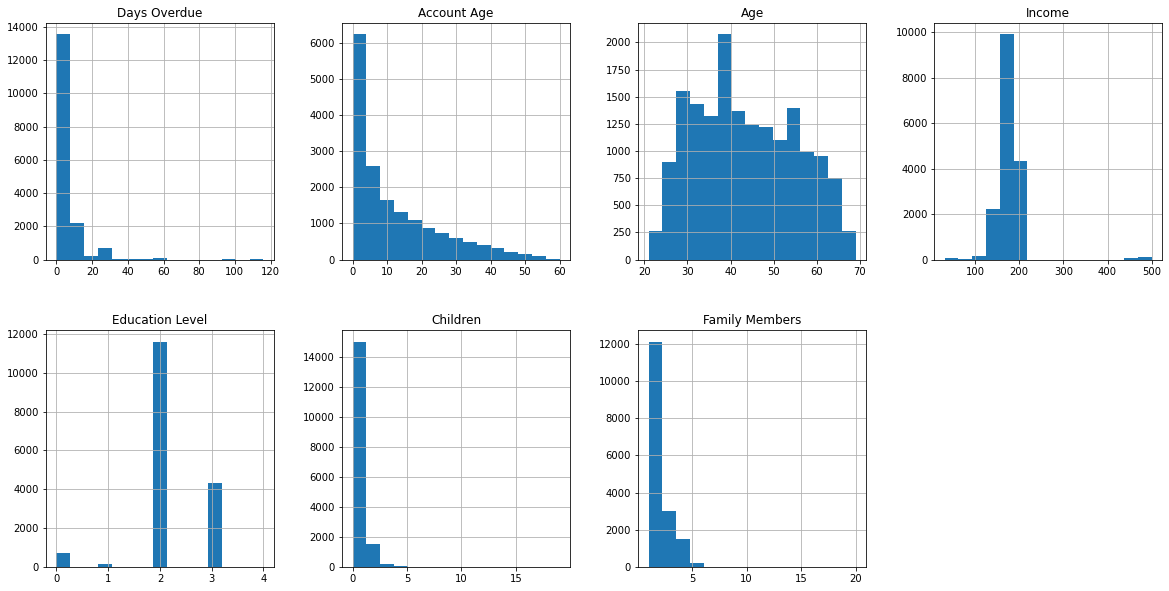

In [32]:
# View spread of numerical variables
credit_data[numerical].hist(bins=15, figsize=(20, 10), layout=(2, 4))

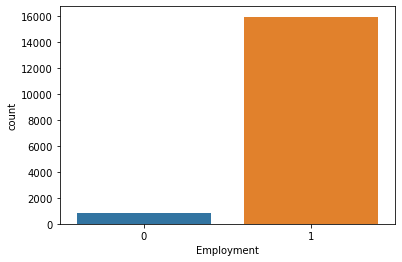

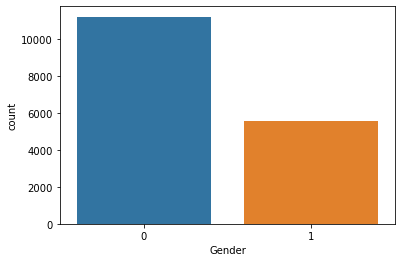

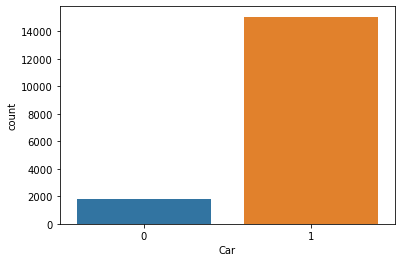

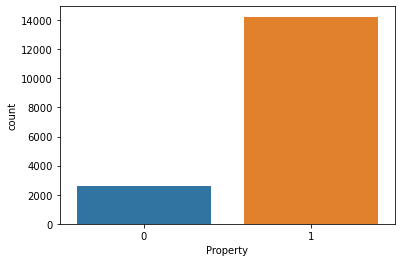

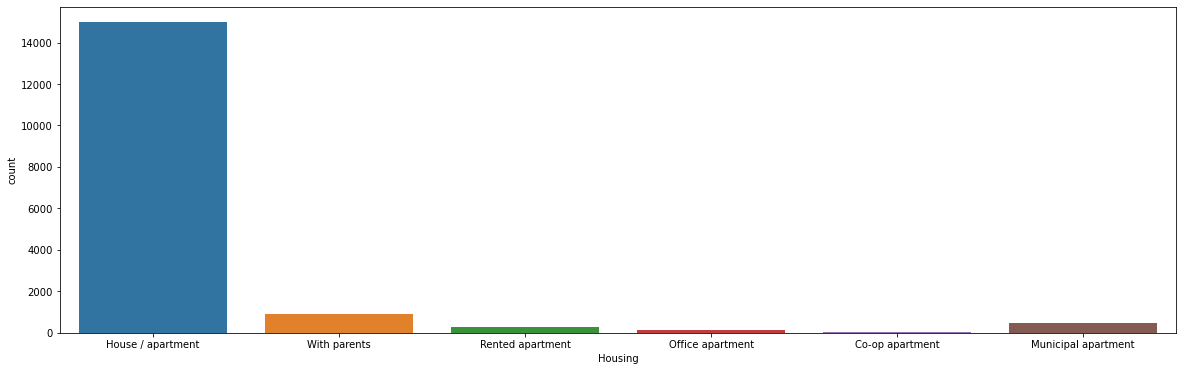

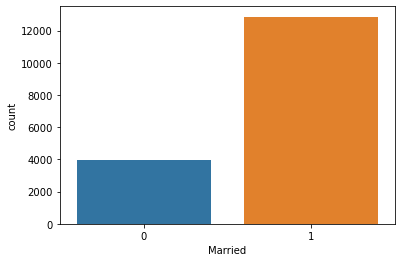

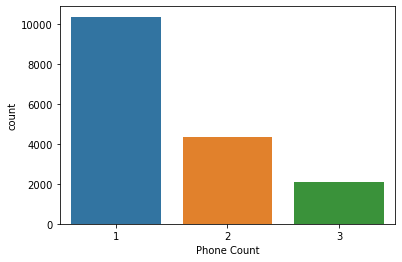

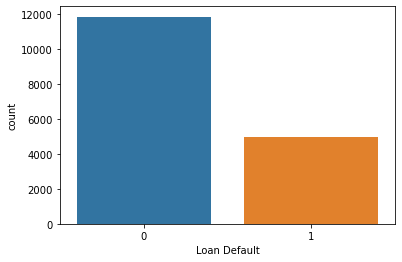

In [33]:
# View spread (count) of categorical variables
for variable in categorical:
    if variable == 'Housing':
        plt.figure(figsize=(20,6))
    sb.countplot(x=credit_data[variable])
    plt.show()

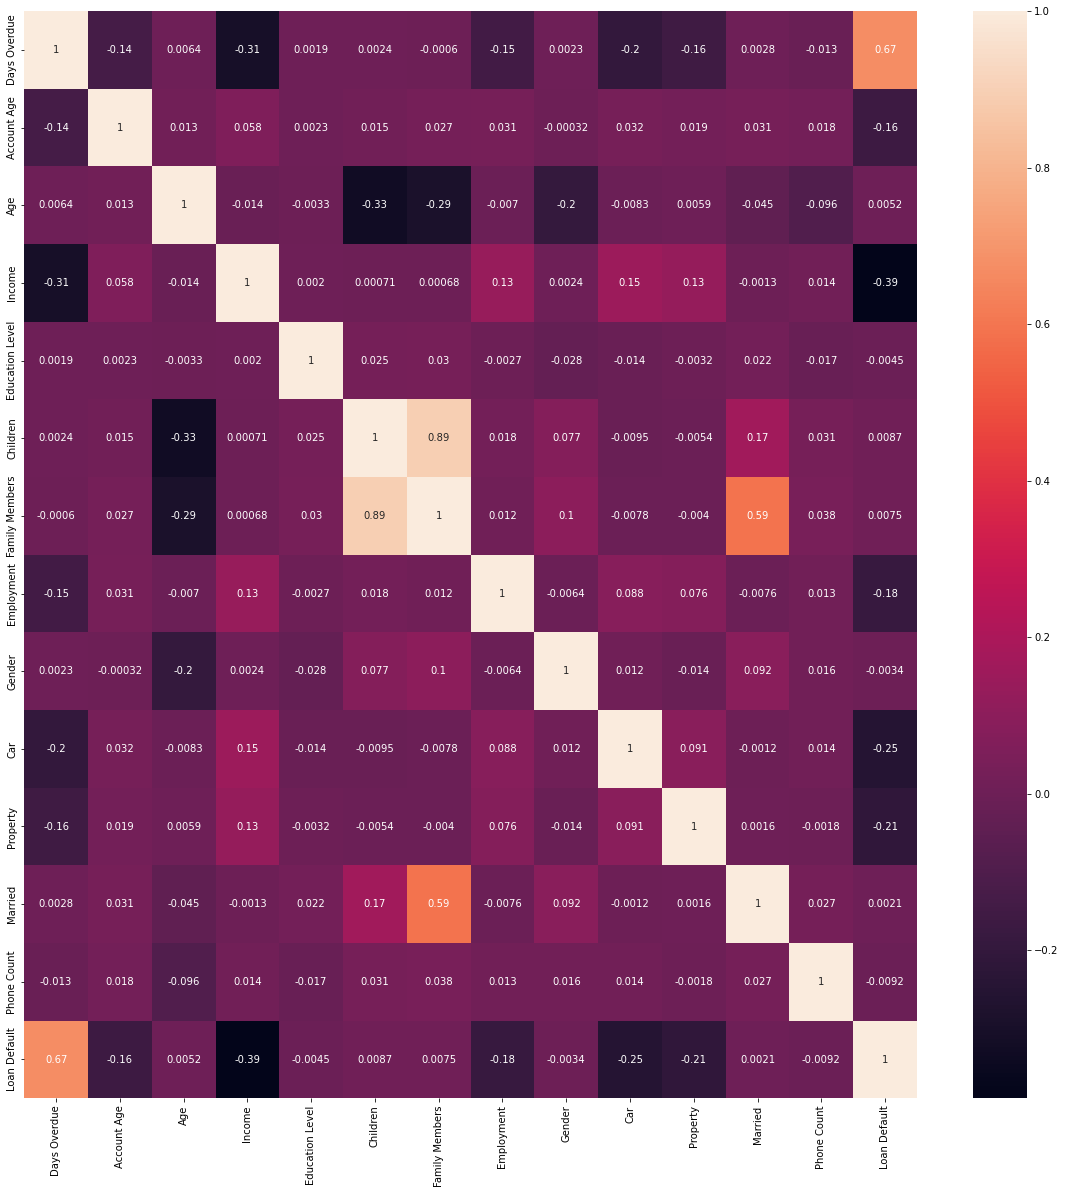

In [34]:
# View correlation of each variable with Days Overdue
cd_corr = credit_data.corr()
plt.figure(figsize=(20,20))
sb.heatmap(cd_corr, annot=True)
plt.show()

#### Based on correlation values, variables to examine further: Property, Car, Employment, Income

<AxesSubplot:xlabel='Property', ylabel='Days Overdue'>

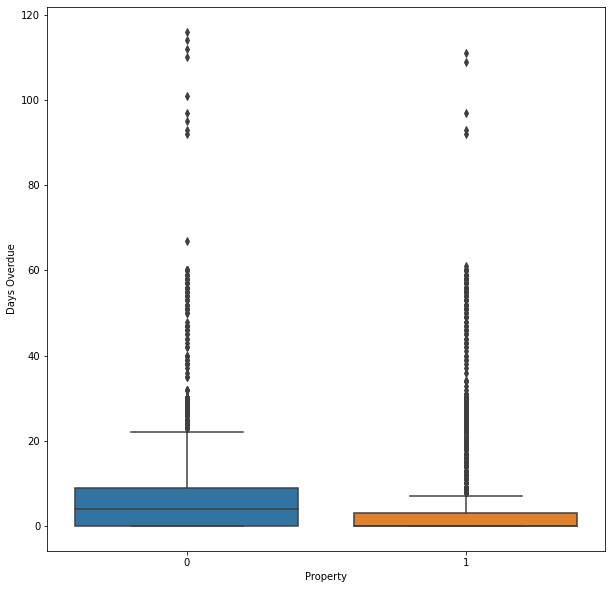

In [35]:
# Examine Property
f = plt.figure(figsize=(10,10))
sb.boxplot(x = 'Property', y = 'Days Overdue', data = credit_data)

<AxesSubplot:xlabel='Car', ylabel='Days Overdue'>

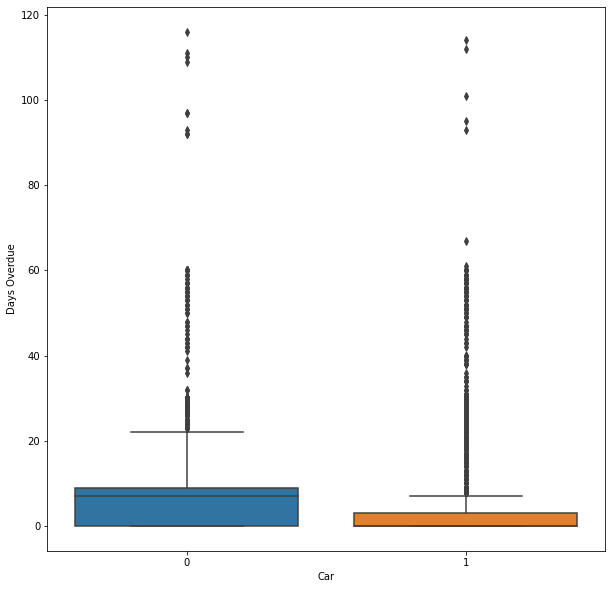

In [36]:
# Examine Car
f = plt.figure(figsize=(10,10))
sb.boxplot(x = 'Car', y = 'Days Overdue', data = credit_data)

<AxesSubplot:xlabel='Employment', ylabel='Days Overdue'>

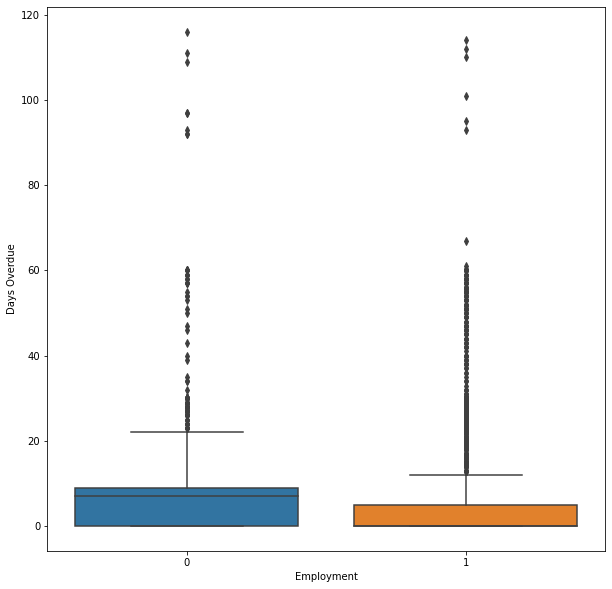

In [37]:
# Examine Employment
f = plt.figure(figsize=(10,10))
sb.boxplot(x = 'Employment', y = 'Days Overdue', data = credit_data)

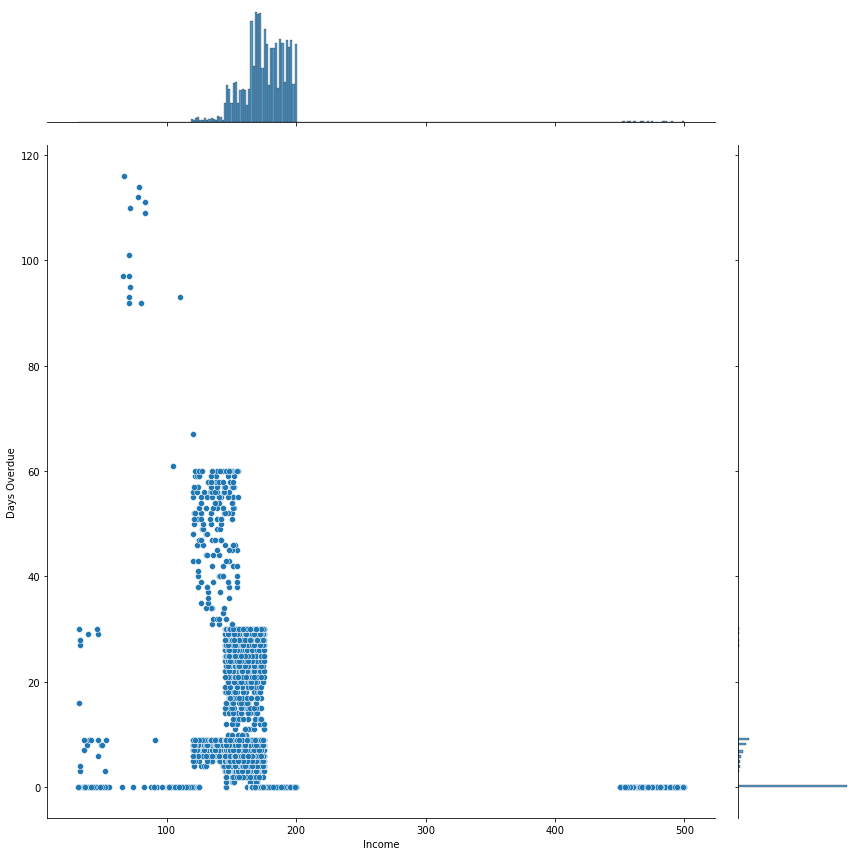

In [38]:
# Examine Income
income = pd.DataFrame(credit_data['Income'])
Days_Overdue = pd.DataFrame(credit_data['Days Overdue'])
jointDF = pd.concat([income, Days_Overdue], axis = 1).reindex(income.index)
sb.jointplot(data = jointDF, x = "Income", y = "Days Overdue", height = 12)

Text(0.5, 1.0, 'Income Distribution (Boxplot)')

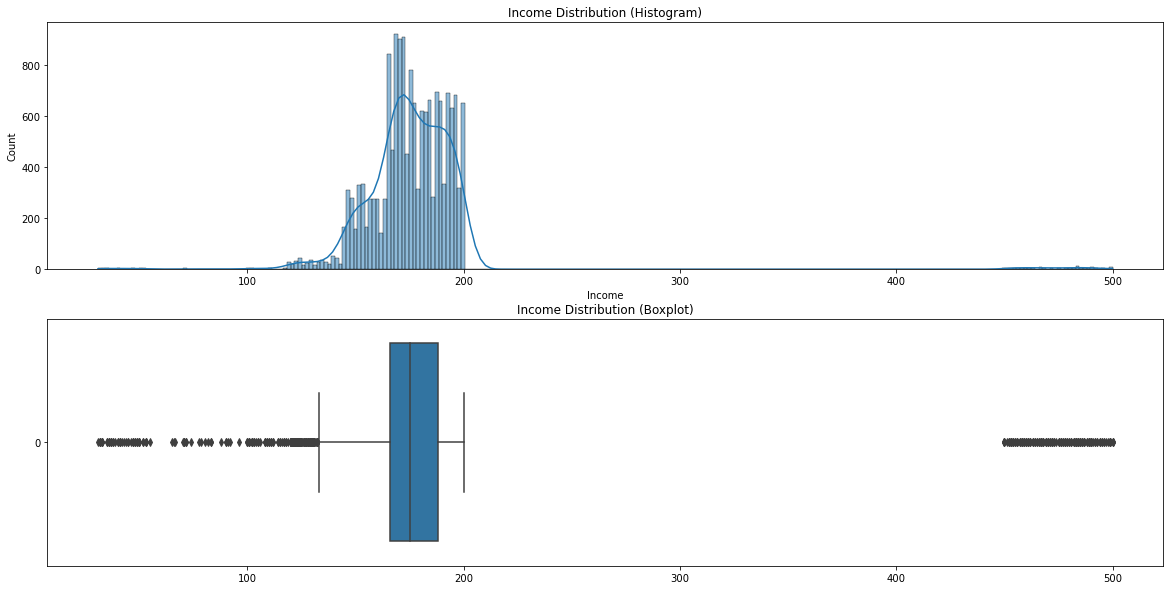

In [39]:
# Income distribution
f, axes = plt.subplots(2,1, figsize=(20,10))

# Histogram
sb.histplot(x = credit_data['Income'], kde=True, ax=axes[0]).set_title("Income Distribution (Histogram)")

# Boxplot
sb.boxplot(data=credit_data['Income'], orient="h", ax=axes[1]).set_title("Income Distribution (Boxplot)")

### Remove Anomaly - IsolationForest

C:\Users\Ryan\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 1.0, 'Income')

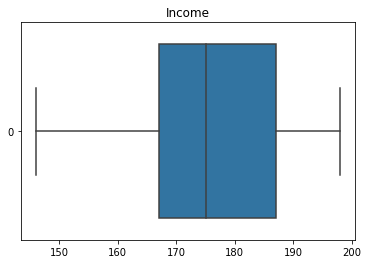

In [40]:
# https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/

from sklearn.ensemble import IsolationForest

# There were extreme outliers for income, hence we remove these from our dataset
income_data = pd.DataFrame(credit_data[['Income']])

# IsolationForest
random_state = np.random.RandomState(42) # Number is irrelevant
model = IsolationForest(n_estimators=250, max_samples='auto', contamination=float(0.1), random_state=random_state) # Contamination indicates the percentage of outliers
model.fit(income_data[['Income']])

income_data['scores'] = model.decision_function(income_data[['Income']])
income_data['anomaly_score'] = model.predict(income_data[['Income']]) # Outlier -1 means true

# Remove outliers from dataset
credit_data.drop(income_data[income_data['anomaly_score']==-1].index.tolist(), inplace=True)
credit_data.reset_index(drop=True, inplace=True)

sb.boxplot(data = credit_data['Income'], orient = "h").set_title("Income") 


#### Extreme right, and left outliers from income have been removed.

### Linear Regression Model - Estimate duration of bad debts

Account Age:
Training Data:
MSE = 48.357148490649976 | R-Squared = 0.021636235745660093 | RMSE = 6.953930434700219
Test Data:
MSE = 47.60936433479737 | R-Squared = 0.022506593356668936 | RMSE = 6.899953937150404
Days Loan Overdue = -0.0799*Account Age + 4.2257

Income:
Training Data:
MSE = 34.90044457164744 | R-Squared = 0.3003519048618599 | RMSE = 5.907659821930122
Test Data:
MSE = 33.684421409335485 | R-Squared = 0.2928847512338624 | RMSE = 5.803828168488061
Days Loan Overdue = -0.2855*Income + 53.4314

Age:
Training Data:
MSE = 50.94247595208457 | R-Squared = 2.3142119909280723e-07 | RMSE = 7.137399803295635
Test Data:
MSE = 45.181577980154316 | R-Squared = -0.0006010798984321664 | RMSE = 6.721724330865877
Days Loan Overdue = -0.0003*Age + 3.3287



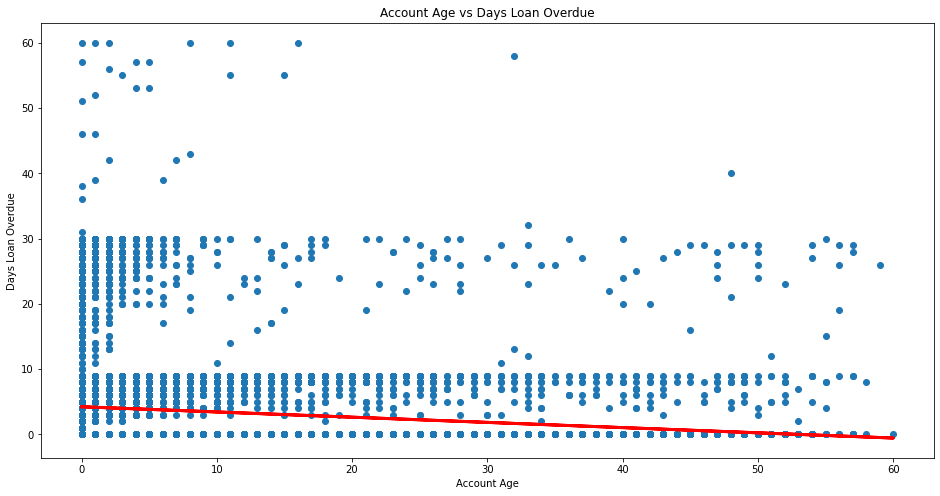

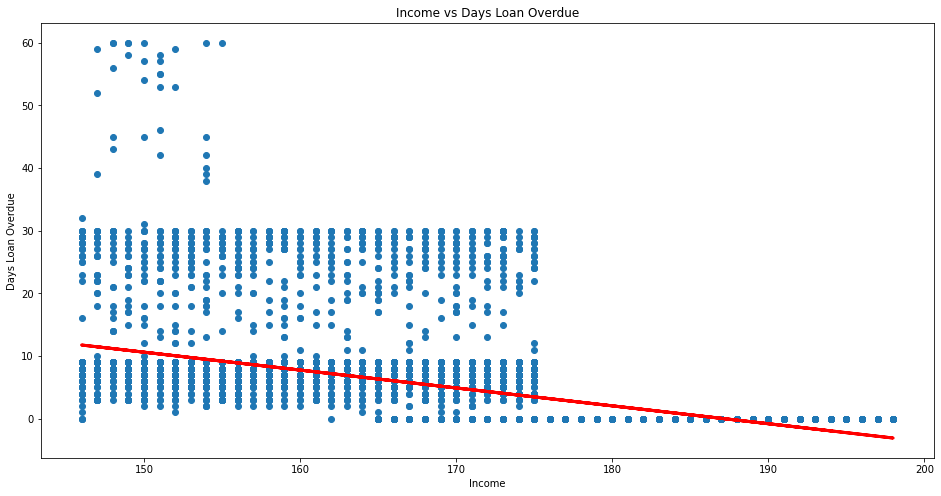

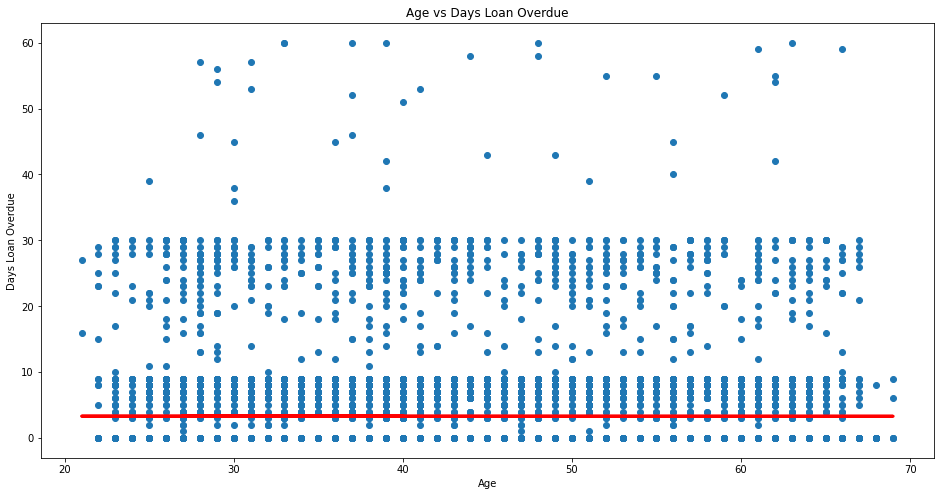

In [41]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Investigate various numerical variables to find the best predictor
variables = ['Account Age', 'Income', 'Age']

# Find the best predictor
for variable in variables:

    x = pd.DataFrame(credit_data[variable])
    y = pd.DataFrame(credit_data['Days Overdue'])

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    reg = LinearRegression()
    reg.fit(x_train, y_train)
    
    
    print(f"{variable}:")
    print(f"Training Data:\nMSE = {mean_squared_error(y_train, reg.predict(x_train))} | R-Squared = {reg.score(x_train, y_train)} | RMSE = {np.sqrt(mean_squared_error(y_train, reg.predict(x_train)))}")
    print(f"Test Data:\nMSE = {mean_squared_error(y_test, reg.predict(x_test))} | R-Squared = {reg.score(x_test, y_test)} | RMSE = {np.sqrt(mean_squared_error(y_test, reg.predict(x_test)))}")

    regLine = reg.intercept_ + reg.coef_ * x_train
    print(f"Days Loan Overdue = {round(reg.coef_[0][0], 4)}*{variable} + {round(reg.intercept_[0], 4)}\n")
    f = plt.figure(figsize=(16, 8))
    plt.scatter(x_train, y_train)
    plt.plot(x_train, regLine, 'r-', linewidth = 3)
    plt.xlabel(f"{variable}")
    plt.ylabel("Days Loan Overdue")
    plt.title(f"{variable} vs Days Loan Overdue")


#### Strongest Linear Correlation between Income and Days of Loan Overdue, however, we can improve our regression model by using the Random Forest Regressor

### Random Forest Regressor - Income vs Days Loan Overdue

Text(0, 0.5, 'Days Loan Overdue')

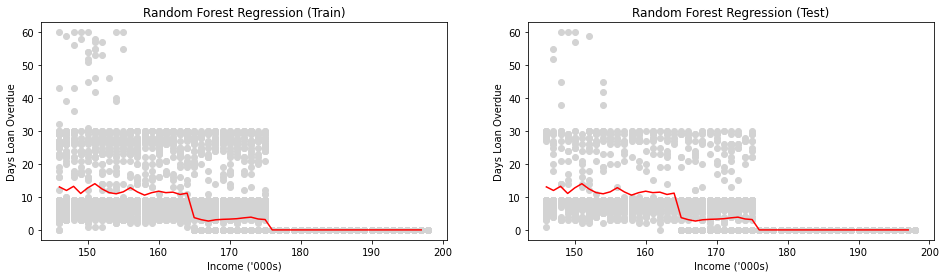

In [42]:
from sklearn.ensemble import RandomForestRegressor

f, axes = plt.subplots(1, 2, figsize = (16, 4))

# Implement Random Forest Regressor
rfr = RandomForestRegressor(n_estimators = 1000, random_state = 42) # Set number of "decisions" to 1000

# Generate train and test set
x = pd.DataFrame(credit_data['Income'])
y = pd.DataFrame(credit_data['Days Overdue'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Train the model on training data
rfr.fit(x_train, y_train['Days Overdue']) 

# View original data points
axes[0].scatter(x_train, y_train, color = '#D3D3D3') 
axes[1].scatter(x_test, y_test, color = '#D3D3D3') 
 
# Check every change in income of 1(000)
x_grid_train = np.arange(min(x_train['Income']), max(x_train['Income']), 1)
x_grid_train = x_grid_train.reshape((len(x_grid_train), 1))

x_grid_test = np.arange(min(x_test['Income']), max(x_test['Income']), 1)
x_grid_test = x_grid_test.reshape((len(x_grid_test), 1))

# View Random Forest Regression Model
axes[0].plot(x_grid_train, rfr.predict(x_grid_train), color = 'red')
axes[1].plot(x_grid_test, rfr.predict(x_grid_test), color = 'red')

axes[0].set_title('Random Forest Regression (Train)')
axes[0].set_xlabel("Income ('000s)")
axes[0].set_ylabel("Days Loan Overdue")

axes[1].set_title('Random Forest Regression (Test)')
axes[1].set_xlabel("Income ('000s)")
axes[1].set_ylabel("Days Loan Overdue")


### Random Forest Classifier - Determine if applicant is eligible to apply for the credit card

###  Prepare Train & Test Set - Stratified k-Fold Cross-Validation

#### Since our dataset was quite unbalanced (most people would be able to pay off their debts), we chose to split our train and test data using k-Fold Cross-Validation with stratified sampling. This method will ensure that the training and the test sets have similar proportion of our target varaible (Loan Default). 

In [43]:
# https://www.rasgoml.com/feature-engineering-tutorials/how-to-do-scikit-learn-stratified-cross-validation-splits

from sklearn.model_selection import StratifiedKFold

def generateSet(variable):
    # Target variable
    y = credit_data[variable]

    # Variables
    x = credit_data[['Employment', 'Car', 'Property', 'Income']]

    # Implement SKF Cross-Validation
    skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) # In general, more splits = lower RMSE 

    # Split train test data
    for train_index, test_index in skf.split(x, y):
        x_train = x.iloc[train_index, :]
        y_train = y[train_index]
        x_test = x.iloc[test_index, :]
        y_test = y[test_index]
    
    # Return train & test set
    return x_train, y_train, x_test, y_test
    

#### Determine ideal threshold to minimise FNR - False Negative means the model predicts that someone has no problems paying off the loan, however, he actually ends up delaying payment or defaulting. Using the threshold method to minimise FNR will increase FPR, however, from bank's perspective, more ideal to remove FNR.

0: Customer paid off loans.
1: Customer delayed payment or defaulted.


Text(0.5, 51.0, '\nClassification Accuracy: 0.8985\nTrue Negative Rate: 0.7377\nFalse Negative Rate: 0.0485\n')

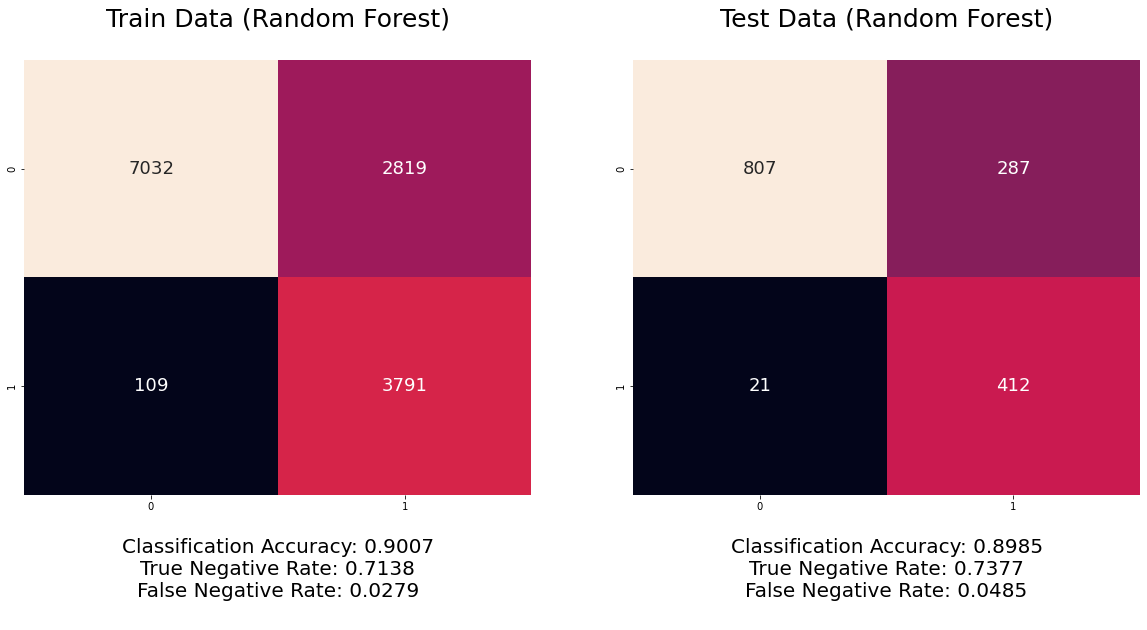

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

f, axes = plt.subplots(1,2, figsize = (20,8))
print("0: Customer paid off loans.\n1: Customer delayed payment or defaulted.")

# Implement Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=5)

# Generate train and test set
x_train, y_train, x_test, y_test = generateSet("Loan Default")

# Select variable
x_train = x_train['Income']
x_train = pd.DataFrame(x_train)

x_test = x_test['Income']
x_test = pd.DataFrame(x_test)

# Train the model on training data
rfc.fit(x_train, y_train)

# Minimise false negative using threshold - balance with FPR
threshold = 0.27 # Alternative Methods: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

# Predict using tree with custom threshold
predicted_proba_train = rfc.predict_proba(x_train)
y_train_pred = (predicted_proba_train[:,1] >= threshold).astype('int')

predicted_proba_test = rfc.predict_proba(x_test)
y_test_pred = (predicted_proba_test[:,1] >= threshold).astype('int')

# Plot confusion matrix for training results
sb.heatmap(confusion_matrix(y_train, y_train_pred), cbar=False, annot = True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])

# Classification accuracy
accuracy = round(rfc.score(x_train, y_train), 4)

# True positive
totalN = sum(confusion_matrix(y_train, y_train_pred)[0])
trueN = round(confusion_matrix(y_train, y_train_pred)[0][0]/totalN, 4)

totalP = sum(confusion_matrix(y_train, y_train_pred)[1])
falseN = round(confusion_matrix(y_train, y_train_pred)[1][0]/totalP, 4)

axes[0].set_title("Train Data (Random Forest)\n", fontsize = 25)
axes[0].set_xlabel(f"\nClassification Accuracy: {accuracy}\nTrue Negative Rate: {trueN}\nFalse Negative Rate: {falseN}\n", fontsize = 20)

# Repeat for test results
sb.heatmap(confusion_matrix(y_test, y_test_pred), cbar=False, annot = True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

accuracy = round(rfc.score(x_test, y_test), 4)

# Concern is on the false negative => Banks do not want to conclude that the customer can pay off loans when he/she cannot
totalN = sum(confusion_matrix(y_test, y_test_pred)[0])
trueN = round(confusion_matrix(y_test, y_test_pred)[0][0]/totalN, 4)

totalP = sum(confusion_matrix(y_test, y_test_pred)[1])
falseN = round(confusion_matrix(y_test, y_test_pred)[1][0]/totalP, 4)

axes[1].set_title("Test Data (Random Forest)\n", fontsize = 25)
axes[1].set_xlabel(f"\nClassification Accuracy: {accuracy}\nTrue Negative Rate: {trueN}\nFalse Negative Rate: {falseN}\n", fontsize = 20)


#### A TNR around 0.7 means that our model is largely accurate at predicting when the applicant will repay debts on time. We minimised the FNR so that our model will be less likely to wrongly predict that the applicant will not face problems repaying debt when they actually do. This is ideal as banks want to avoid giving loans to people who might default.

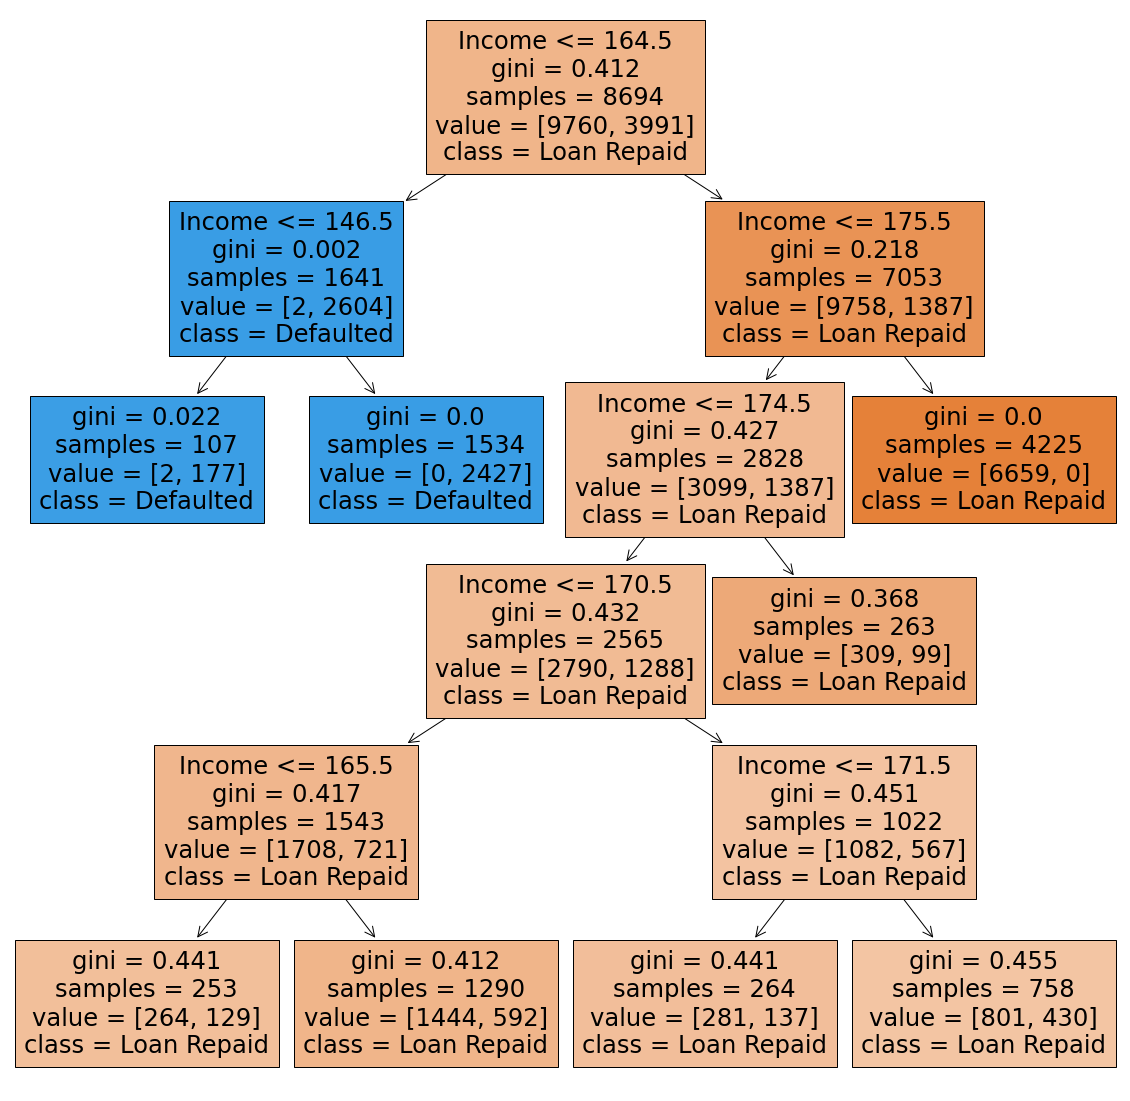

In [45]:
from sklearn import tree
# The random forest has 1000 decision trees, we observe 1 to see their individual accuracy

plt.figure(figsize=(20,20))
tree.plot_tree(rfc.estimators_[0], feature_names=x_test.columns, filled=True, class_names = ["Loan Repaid", "Defaulted"])
plt.show()


#### As evinced from the high gini coefficients in the tree above, we can see that predicting using a single decision tree alone might be inaccurate. Hence, we improved our model by using a random forest, which takes a 1000 (as set by n_estimators) and concludes via majority voting. This allowed us to achieve a higher classification accuracy.

### Tensorflow - Determine probability of loan default using multiple variables

In [46]:
# https://www.digitalocean.com/community/tutorials/how-to-build-a-deep-learning-model-to-predict-employee-retention-using-keras-and-tensorflow

import keras
from keras.models import Sequential
from keras.layers import Dense

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler

# Extract variables and target
x = credit_data[['Employment', 'Car', 'Property', 'Income']].values
y = credit_data['Loan Default'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Prepare data for Tensorflow
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Initiate classifier
classifier = Sequential()
classifier.add(Dense(9, kernel_initializer="uniform", activation="relu", input_dim=4))
classifier.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])

# Check that parameters are trainable
classifier.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 45        
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Implement classifier
classifier.fit(x_train, y_train, batch_size = 10, epochs = 50)


Epoch 1/50
1070/1070 [==============================] - 2s 1ms/step - loss: 0.3554 - accuracy: 0.8735
Epoch 2/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2326 - accuracy: 0.8955
Epoch 3/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2304 - accuracy: 0.8937
Epoch 4/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2295 - accuracy: 0.8935
Epoch 5/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2292 - accuracy: 0.8934
Epoch 6/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2291 - accuracy: 0.8941
Epoch 7/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2291 - accuracy: 0.8918
Epoch 8/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2287 - accuracy: 0.8955
Epoch 9/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.2285 - accuracy: 0.8925
Epoch 10/50
1070/1070 [==============================] - 1s 1ms/step - loss: 0.228

0: Customer paid off loans.
1: Customer delayed payment or defaulted.


Text(0.5, 51.0, '\nClassification Accuracy: 0.8831')

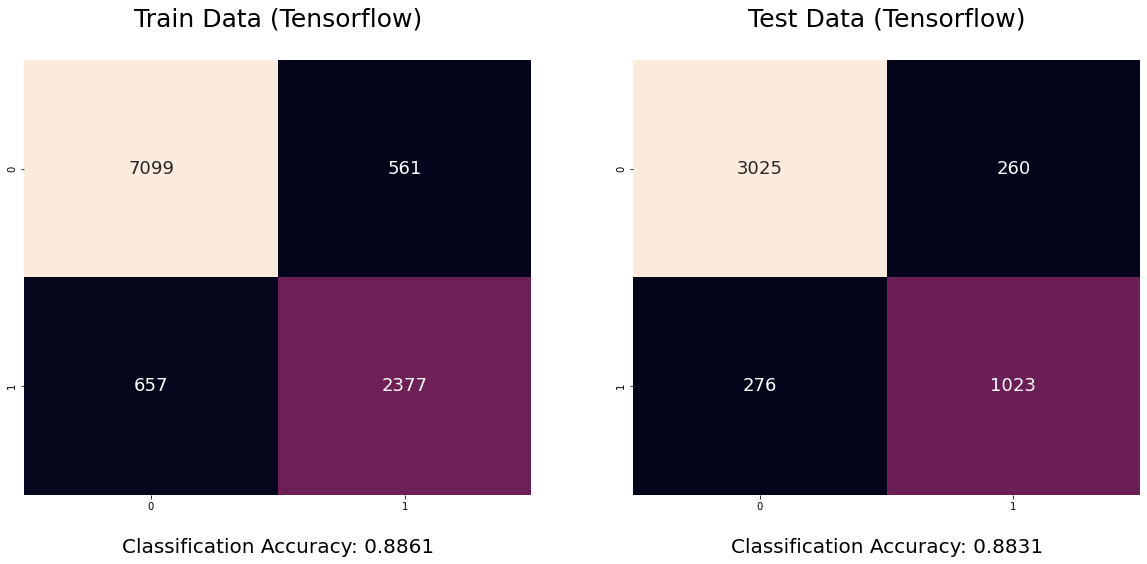

In [48]:
# Predict using classifier
y_pred_train = classifier.predict(x_train)
y_pred_train = (y_pred_train > 0.5) # Above 50% probability of defaulting (threshold) => 1 (Loan defaulted)

y_pred_test = classifier.predict(x_test)
y_pred_test = (y_pred_test > 0.5)

# Visualise using heatmap for train and test set
f, axes = plt.subplots(1,2, figsize = (20,8))
print("0: Customer paid off loans.\n1: Customer delayed payment or defaulted.")

# Classification accuracy - train
total = len(y_pred_train)
accuracy = round((int(confusion_matrix(y_train, y_pred_train)[0][0]) + int(confusion_matrix(y_train, y_pred_train)[1][1]))/total, 4)

sb.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, cbar=False, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
axes[0].set_title("Train Data (Tensorflow)\n", fontsize = 25)
axes[0].set_xlabel(f"\nClassification Accuracy: {accuracy}", fontsize = 20)

# Classification accuracy - test
total = len(y_pred_test)
accuracy = round((int(confusion_matrix(y_test, y_pred_test)[0][0]) + int(confusion_matrix(y_test, y_pred_test)[1][1]))/total, 4)

sb.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cbar=False, fmt=".0f", annot_kws={"size":18}, ax=axes[1])
axes[1].set_title("Test Data (Tensorflow)\n", fontsize = 25)
axes[1].set_xlabel(f"\nClassification Accuracy: {accuracy}", fontsize = 20)


### Insights from Tensorflow Model: Decide if applicant is eligible to apply for the credit card

In [49]:
# Get relevant information from applicant
applicant_income = employment_bool = car_bool = property_bool = -1
while applicant_income <= 0:
        applicant_income = int(input("Enter your annual income: "))/1000
while employment_bool != '0' and employment_bool != '1':
    employment_bool = input("Are you employed? [1 for yes | 0 for no]: ")
while car_bool != '0' and car_bool != '1':
    car_bool = input("Do you have a car? [1 for yes | 0 for no]: ")
while property_bool != '0' and property_bool != '1':
    property_bool = input("Do you own property? [1 for yes | 0 for no]: ")

# Predict probability of loan default using applicant's information
new_pred = classifier.predict(sc.transform(np.array([[employment_bool,car_bool,property_bool,applicant_income]])))
card_approved = (new_pred < 0.5)[0][0] # Criteria: Probability of defaulting < 50% 

# Print decision
if card_approved:
    print("Eligible!")
else:
    print(f"Not eligible")


Enter your annual income: 169000
Are you employed? [1 for yes | 0 for no]: 1
Do you have a car? [1 for yes | 0 for no]: 1
Do you own property? [1 for yes | 0 for no]: 1
Eligible!


#### Income of 169,000 with car, property and employment: Loan Granted <br>Income of 169,000 without car, property and employment: Loan not Granted

#### ==============================================================================